In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.units as u

from typing import Tuple
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle, concatenate

plt.rc('text', usetex=True)
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

# Consolidate data from different fields

In [2]:
COMMON_SURVEY_KEYS = {
    'es1': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        # 'mag_U_VOICE', # no U band for wcdfs
        'mag_G_DES',
        'mag_R_DES',
        'mag_I_DES',
        # 'mag_Z_DES', # drop
        # 'mag_Y_DES', # drop
        'mag_Z_VIDEO', #
        'mag_Y_VIDEO', #
        'mag_J_VIDEO', 
        'mag_H_VIDEO', 
        'mag_Ks_VIDEO', 
        'mag_CH1',
        'mag_CH2'
        ],
    'wcdfs': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        'mag_R_VOICE',
        'mag_G_HSC',
        'mag_I_HSC',
        'mag_Z_HSC',
        'mag_Y_VIDEO', 
        'mag_J_VIDEO', 
        'mag_H_VIDEO',  
        'mag_Ks_VIDEO', 
        'mag_CH1',
        'mag_CH2'
    ],
    'xmmlss': [
        'f_MIPS24',
        'f_MIPS70',
        'f_MIPS160',
        'f_PACS100',
        'f_PACS160',
        'f_SPIRE250',
        'f_SPIRE350',
        'f_SPIRE500',
        # 'mag_U_CFHT', # no U band for wcdfs
        'mag_G_HSC',
        'mag_R_HSC',
        'mag_I_HSC',
        'mag_Z_HSC', #
        'mag_Y_HSC', #
        # 'mag_Z_VIDEO', # drop
        # 'mag_Y_VIDEO', # drop
        'mag_J_VIDEO',
        'mag_H_VIDEO', 
        'mag_Ks_VIDEO', 
        'mag_CH1',
        'mag_CH2'
    ]
}

In [3]:
fits_data = np.array(fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/es1.v1.fits')[1].data)
fits_data = np.hstack((fits_data, fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/wcdfs.v1.fits')[1].data))
fits_data = np.hstack((fits_data, fits.open('/Volumes/T7/ay_98_data/Zou_data/sed_catalog/xmmlss.v1.fits')[1].data))

## Photometry

In [4]:
final_photometry = {
    'sorted_filters': ['G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500'],
    'data': None,  # to fill in
    'sorted_wavelengths': [365, 475, 620, 750, 880, 980, 1250, 1650, 2150, 3550, 4500, 24000, 70000, 100000, 160000, 250000, 350000, 500000],  # nm
    'data_err': None,  # to fill in
    'tractor_id': None,  # to fill in
}

for field in ('es1', 'wcdfs', 'xmmlss'):
    with open(f'/Users/adamboesky/Research/ay98/clean_data/{field}_preprocessed.pkl', 'rb') as f:
        field_data = pickle.load(f)
        # Iterate through the fields of the photometry data and add to final field accordingly
        temp_data = None
        temp_err = None
        temp_tractor_ids = np.array(field_data['photometry']['tractor_id']).flatten()
        for filt, filt_data, filt_err, tractor_id in zip(field_data['photometry']['sorted_filters'], field_data['photometry']['data'].T, field_data['photometry']['data_err'].T, field_data['photometry']['tractor_id']):
            if filt in COMMON_SURVEY_KEYS[field]:  # make sure field is desired
                if temp_data is None:
                    print(f'Data {field} with shape {filt_data.shape}')
                    temp_data = np.atleast_2d(filt_data).T
                    temp_err = np.atleast_2d(filt_err).T
                else:
                    temp_data = np.hstack((temp_data, np.atleast_2d(filt_data).T))
                    temp_err = np.hstack((temp_err, np.atleast_2d(filt_err).T))

        if final_photometry['data'] is None:
            final_photometry['data'] = temp_data
            final_photometry['data_err'] = temp_err
            final_photometry['tractor_id'] = temp_tractor_ids
        else:
            final_photometry['data'] = np.vstack((final_photometry['data'], temp_data))
            final_photometry['data_err'] = np.vstack((final_photometry['data_err'], temp_err))
            final_photometry['tractor_id'] = np.concatenate((final_photometry['tractor_id'], temp_tractor_ids))

# Append our unique identifier
final_photometry['gal_id'] = np.arange(0, len(final_photometry['tractor_id']), 1)

Data es1 with shape (762073,)
Data wcdfs with shape (745326,)
Data xmmlss with shape (1183643,)


In [7]:
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_photometry.pkl', 'wb') as f:
    pickle.dump(final_photometry, f)

In [5]:
def get_coords_for_id(gal_id: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)
    return coord_lookup_table[coord_lookup_table['gal_id'] == gal_id][0][1], coord_lookup_table[coord_lookup_table['gal_id'] == gal_id][0][2]


def get_coords_for_ids(gal_ids: np.bytes_, lookup_table_path: str = '/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl') -> Tuple[float, float]:
    """Function used to get the coordinates of a given tractor ID."""
    with open(lookup_table_path, 'rb') as f:
        coord_lookup_table = pickle.load(f)
    # index_dict = {value: index for index, value in enumerate(coord_lookup_table['tractor_id'])}
    # indices = [index_dict.get(tid, -1) for tid in tractor_ids]

    # indices = []
    # for tid in tractor_ids:
    #     idx = np.where(tractor_ids == tid)[0]
    #     indices.append(idx[0])
    #     if len(idx) > 1:
    #         raise ValueError('There are multiple Tractor_IDs that match the given value.')
    # return coord_lookup_table[indices][['RA', 'DEC']]
    # Sort 'b' and remember the original indices

    sorted_inds = np.argsort(coord_lookup_table['gal_id'])
    lup_tab_sorted = coord_lookup_table[sorted_inds]
    print('Sorted')
    
    # Find the sorted indices of 'a' in 'b'
    indices_in_b_sorted = np.searchsorted(lup_tab_sorted['gal_id'], gal_ids, side='left')
    print('Search complete')
    
    # Make sure that all elements of 'a' are actually present in 'b'
    indices_in_b_sorted = indices_in_b_sorted[indices_in_b_sorted < len(coord_lookup_table['gal_id'])]
    valid_mask = lup_tab_sorted['gal_id'][indices_in_b_sorted] == gal_ids
    indices_in_b_sorted = indices_in_b_sorted[valid_mask]
    print('Validation complete')

    # Take the sorted indices and map back to original indices in 'b'
    all_indices = lup_tab_sorted[indices_in_b_sorted]
    
    return all_indices

## Galaxy characteristics

In [6]:
final_cat = {}

for field in ('es1', 'wcdfs', 'xmmlss'):
    with open(f'/Users/adamboesky/Research/ay98/clean_data/{field}_preprocessed.pkl', 'rb') as f:
        cat_data = pickle.load(f)

        # Iterate through the fields of the photometry data and add to final field accordingly
        temp_keys = None
        temp_err_keys = None
        temp_data = None
        temp_err = None
        temp_tractor_ids = np.array(field_data['photometry']['tractor_id']).flatten()
        for key, err_key, data, err_data in zip(cat_data['catalog']['keys'], cat_data['catalog']['err_keys'], cat_data['catalog']['data'].T, cat_data['catalog']['data_err'].T):
            if key in ['Mstar_best', 'SFR_best']:
                key = f'log_{key}'

            print(f'Data {field} with shape {data.shape}')
            if temp_data is None:
                temp_data = np.atleast_2d(data).T
                temp_err = np.atleast_2d(err_data).T
                temp_keys = [key]
                temp_err_keys = [err_key]
            else:
                temp_data = np.hstack((temp_data, np.atleast_2d(data).T))
                temp_err = np.hstack((temp_err, np.atleast_2d(err_data).T))
                temp_keys.append(key)
                temp_err_keys.append(err_key)

        if final_cat.get('data') is not None:
            final_cat['data'] = np.vstack((final_cat['data'], temp_data))
            final_cat['data_err'] = np.vstack((final_cat['data_err'], temp_err))
            final_cat['tractor_id'] = np.concatenate((final_cat['tractor_id'], temp_tractor_ids))
        else:
            final_cat['data'] = temp_data
            final_cat['data_err'] = temp_err
            final_cat['keys'] = temp_keys
            final_cat['err_keys'] = temp_err_keys
            final_cat['tractor_id'] = temp_tractor_ids

# Append our unique identifier
final_cat['gal_id'] = np.arange(0, len(final_cat['tractor_id']), 1)

Data es1 with shape (762073,)
Data es1 with shape (762073,)
Data es1 with shape (762073,)
Data wcdfs with shape (745326,)
Data wcdfs with shape (745326,)
Data wcdfs with shape (745326,)
Data xmmlss with shape (1183643,)
Data xmmlss with shape (1183643,)
Data xmmlss with shape (1183643,)


In [9]:
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_cat.pkl', 'wb') as f:
    pickle.dump(final_cat, f)

# EDA plots

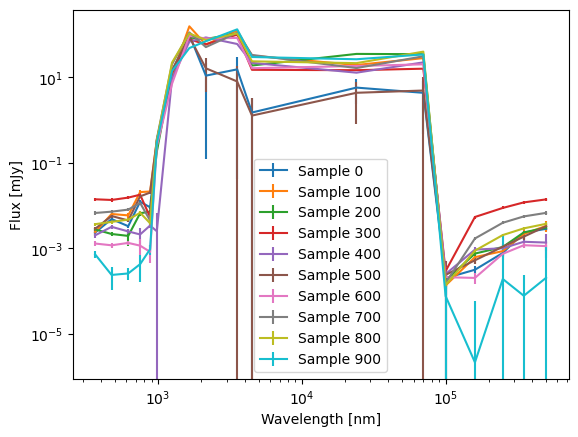

In [10]:
for sample in np.arange(0, 1000, 100):
    plt.errorbar(final_photometry['sorted_wavelengths'], final_photometry['data'][sample], yerr=final_photometry['data_err'][sample], label=f'Sample {sample}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux [mJy]')
plt.legend()
plt.show()

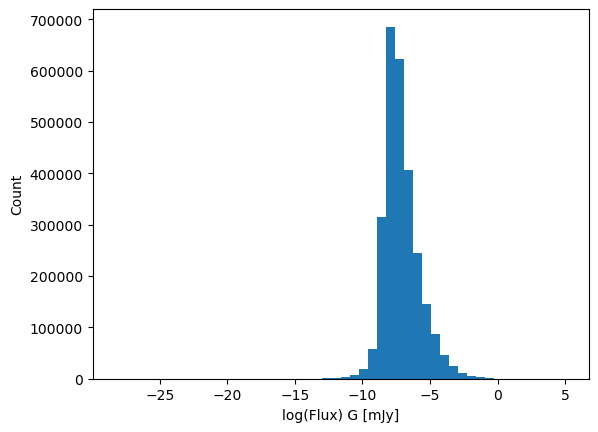

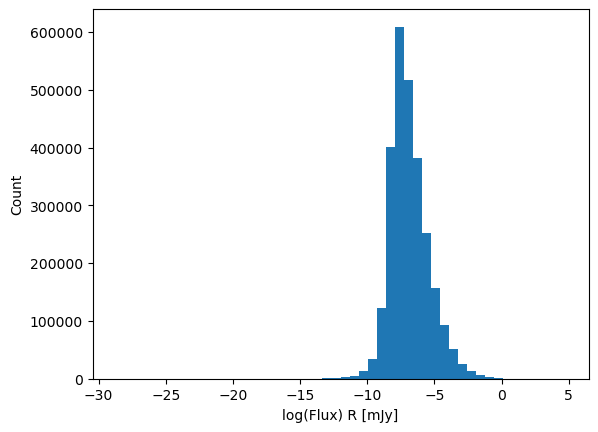

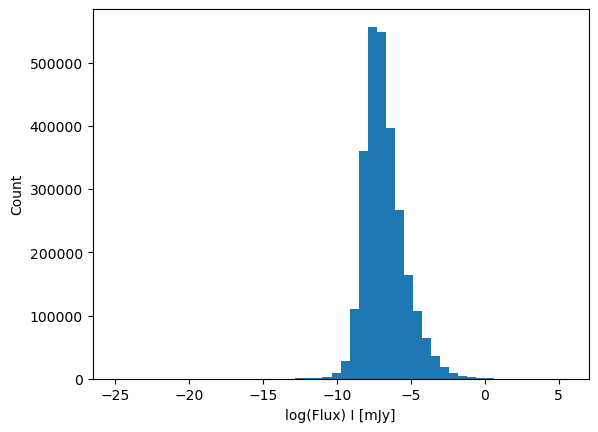

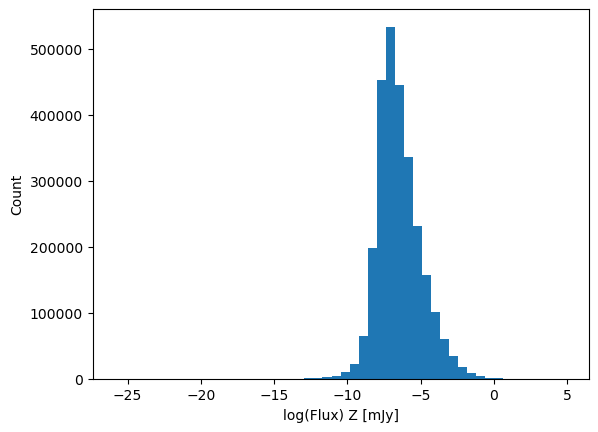

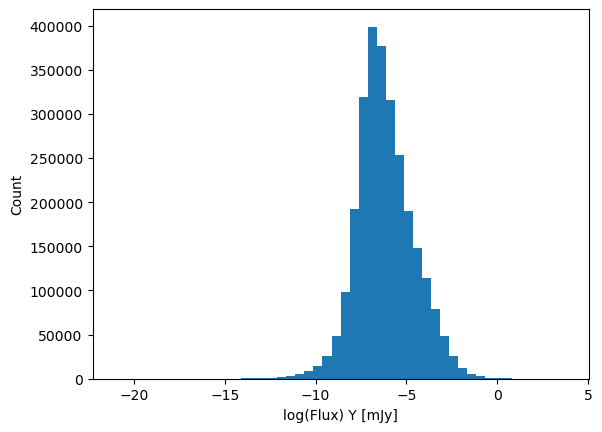

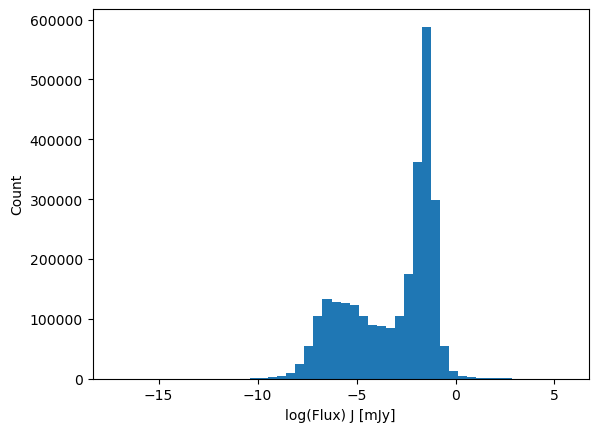

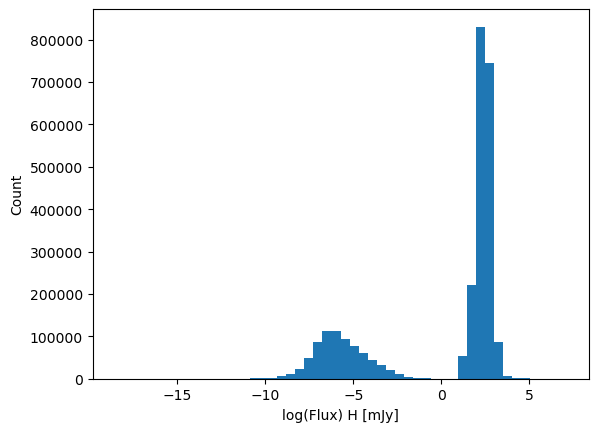

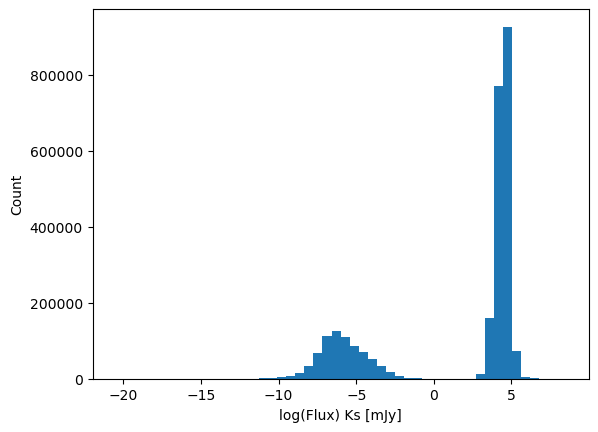

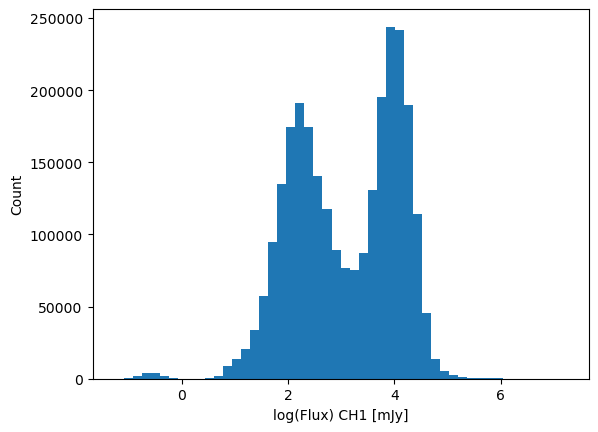

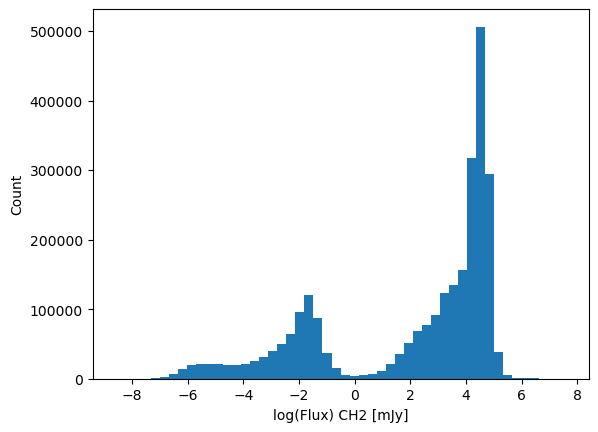

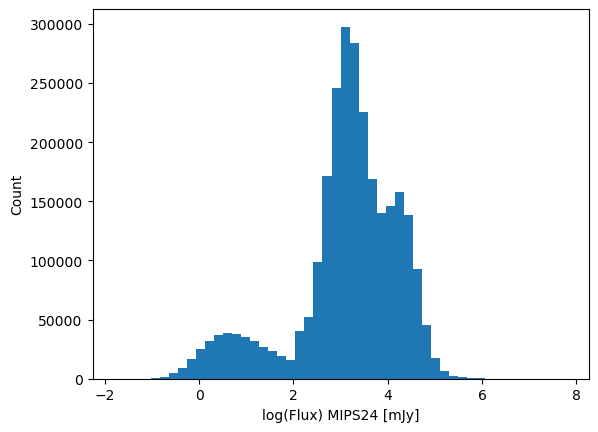

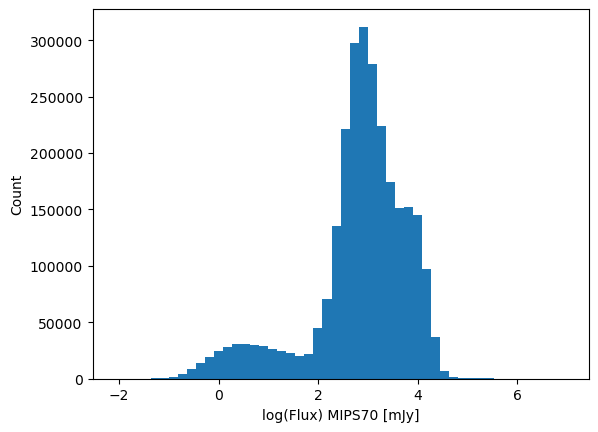

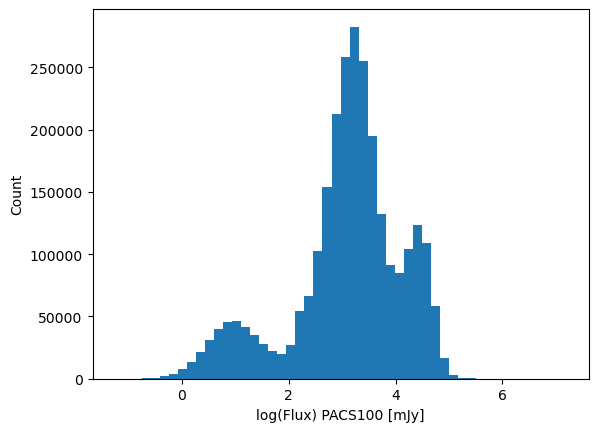

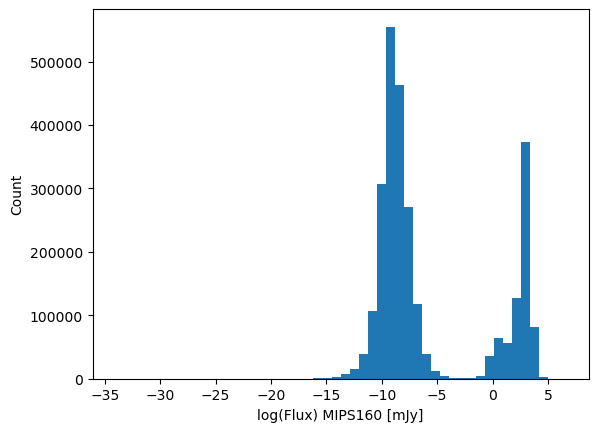

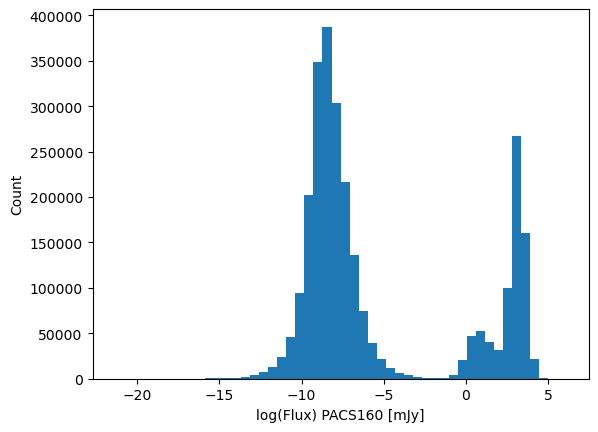

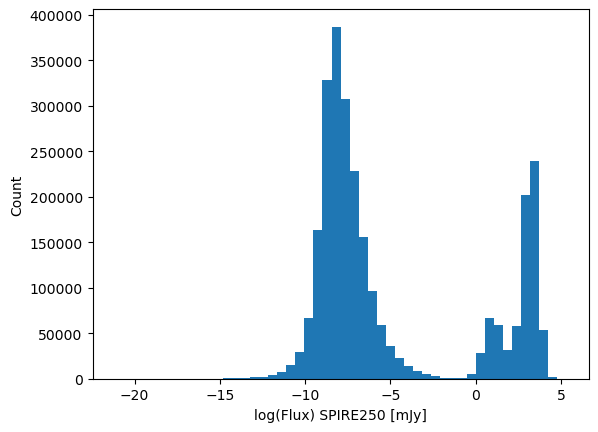

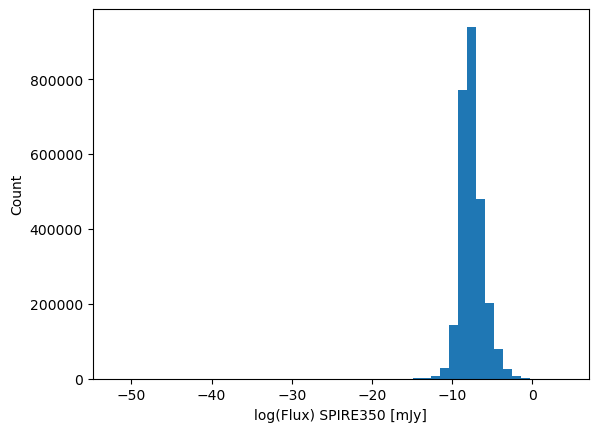

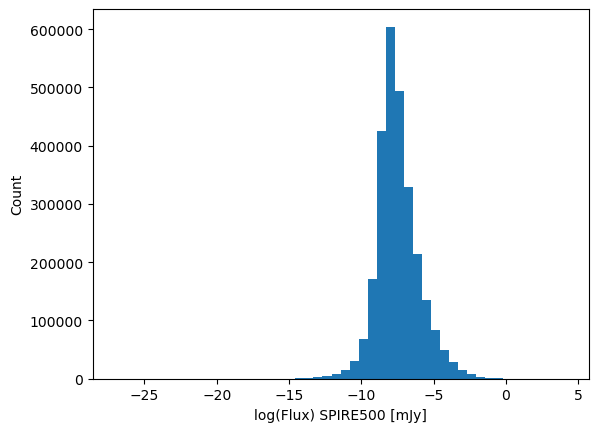

In [11]:
# Filter histograms
for filter, vals in zip(final_photometry['sorted_filters'], final_photometry['data'].T):
    plt.figure()
    plt.hist(np.log(vals), bins=50)
    plt.xlabel(f'log(Flux) {filter} [mJy]')
    plt.ylabel('Count')
    plt.show()

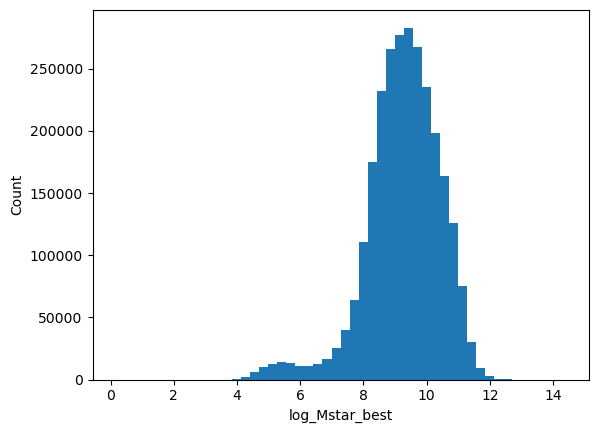

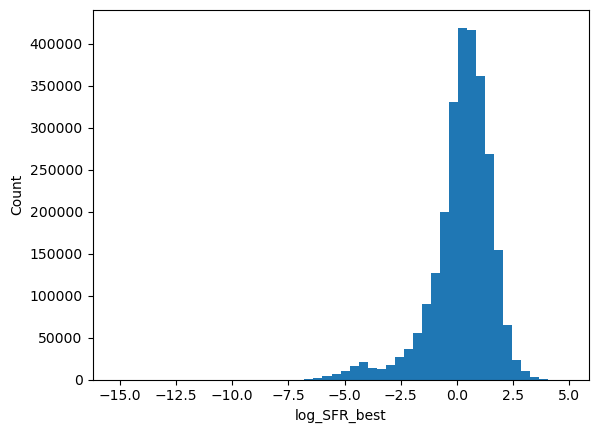

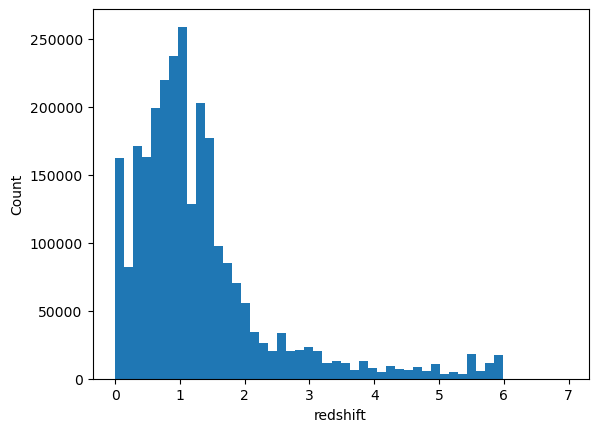

In [12]:
for out_k, vals in zip(final_cat['keys'], final_cat['data'].T):
    plt.figure()
    plt.hist(vals, bins=50)
    plt.ylabel('Count')
    plt.xlabel(out_k)
    plt.show()

In [13]:
print(fits_data['ztype'])
print(np.unique(fits_data['ztype']))
print('# of zphot: \t', np.sum(fits_data['ztype'] == b'zphot'))
print('# of zspec: \t', np.sum(fits_data['ztype'] == b'zspec'))

[b'zphot' b'zphot' b'nan' ... b'zphot' b'zphot' b'zphot']
[b'nan' b'zphot' b'zspec']
# of zphot: 	 2733754
# of zspec: 	 99037


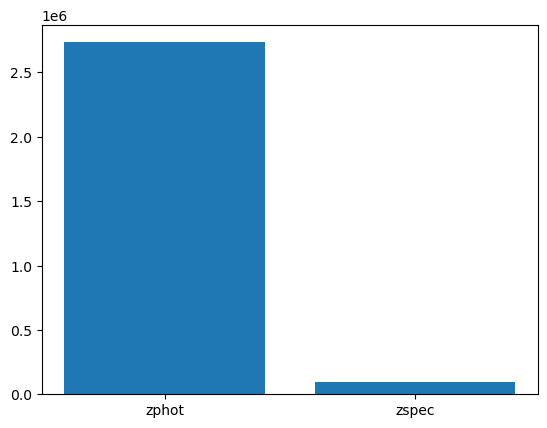

In [14]:
plt.bar(['zphot', 'zspec'], [np.sum(fits_data['ztype'] == b'zphot'), np.sum(fits_data['ztype'] == b'zspec')])
plt.show()

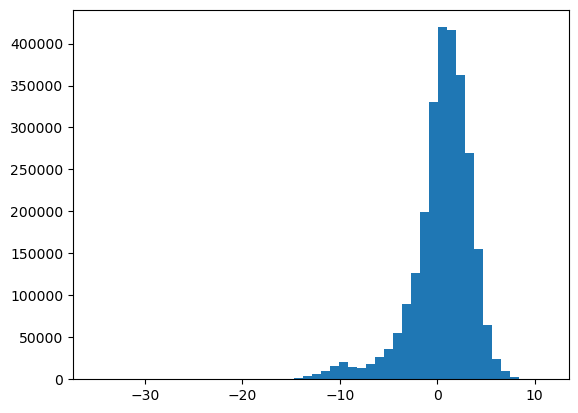

In [15]:
plt.hist(np.log(fits_data['SFR_best']), bins=50)
plt.show()

In [16]:
with open(f'/Users/adamboesky/Research/ay98/clean_data/all_cat.pkl', 'rb') as f:
        all_cat = pickle.load(f)
cat = all_cat['data']
cat_err = all_cat['data_err']

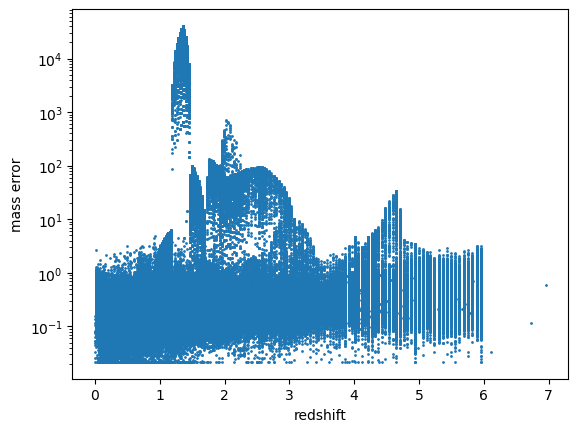

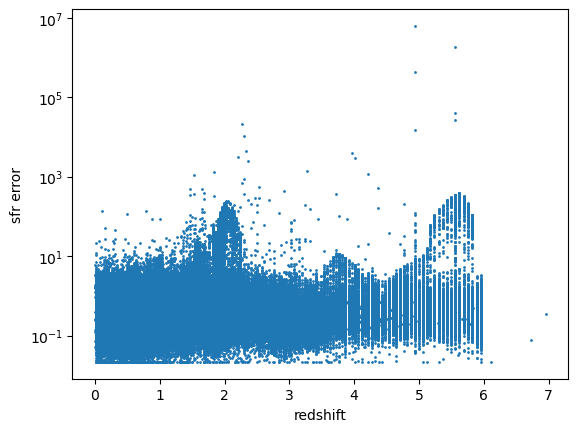

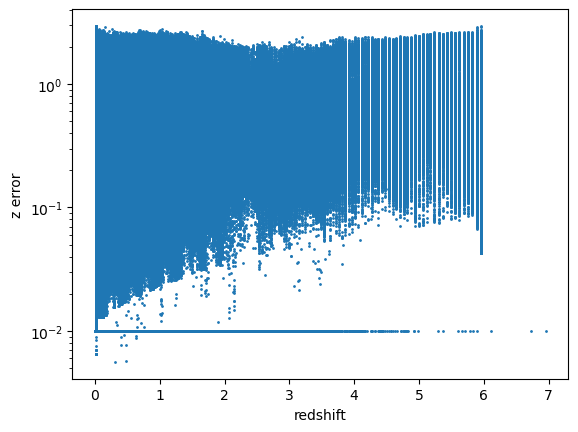

In [17]:
for ind, field in enumerate(('mass', 'sfr', 'z')):
    plt.figure()
    plt.scatter(cat[:, 2], cat_err.T[ind], s=1)
    plt.xlabel('redshift')
    plt.ylabel(f'{field} error')
    plt.yscale('log')
    plt.show()

Galaxy with tractor id=0 which has coordinates (b'644246429973', 9.170842439066458)


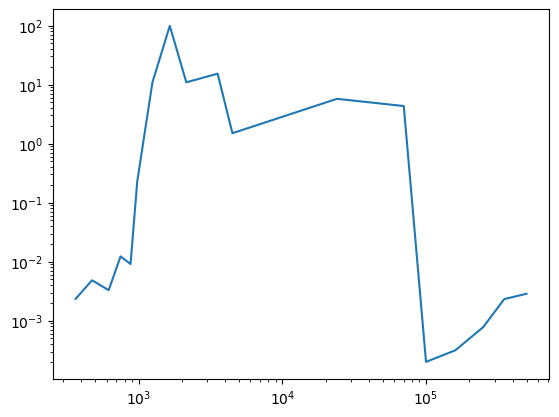

In [22]:
gal_id = final_photometry['gal_id'][0]
print(f"Galaxy with tractor id={gal_id} which has coordinates {get_coords_for_id(gal_id)}")
plt.plot(final_photometry['sorted_wavelengths'], final_photometry['data'][0])
plt.xscale('log')
plt.yscale('log')

Galaxy with tractor id=b'644246429998' which has coordinates (b'644246429998', 8.678235333001934)


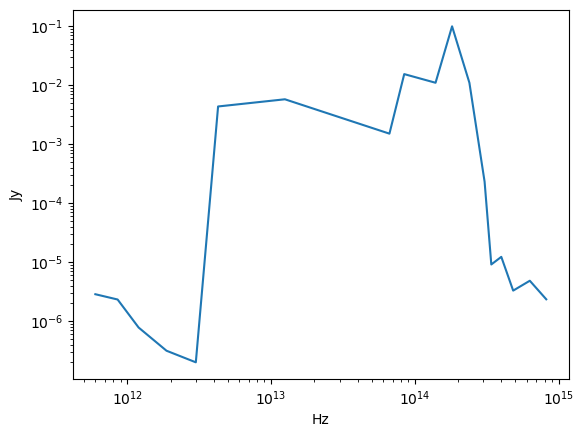

In [24]:
gal_id = final_photometry['gal_id'][22]
print(f"Galaxy with tractor id={t_id} which has coordinates {get_coords_for_id(gal_id)}")
plt.plot( 2.998E17 / np.array(final_photometry['sorted_wavelengths']), final_photometry['data'][0]/1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hz')
plt.ylabel('Jy')
plt.show()

Galaxy with tractor id=999 which has coordinates (b'644246431133', 9.940671216027761)


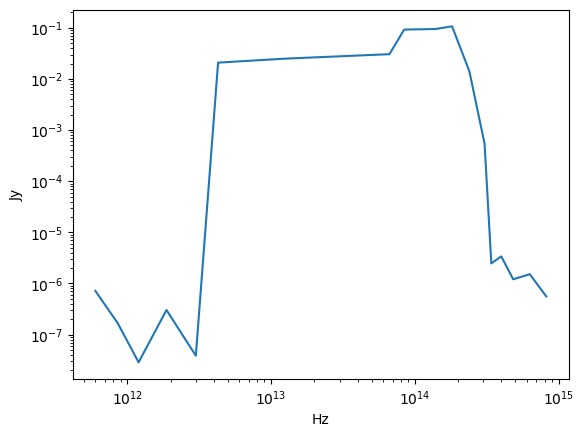

In [25]:
indx = 999
gal_id = final_photometry['gal_id'][indx]
print(f"Galaxy with tractor id={gal_id} which has coordinates {get_coords_for_id(gal_id)}")
plt.plot(2.998E17 / np.array(final_photometry['sorted_wavelengths']), final_photometry['data'][indx]/1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hz')
plt.ylabel('Jy')
plt.show()

# Mapping SNe to our galaxies

Save a file to lookup coordinates for a given tractor ID

In [7]:
final_cat['data'][:, 0]

array([ 9.62903439,  8.2620419 ,  8.33771126, ...,  9.84605304,
        8.27052041, 10.67830631])

In [8]:
# Sort our data so that we can put the gal_id identifier on
value_to_index = {value: idx for idx, value in enumerate(np.log10(fits_data['Mstar_best']))}
data_indices = np.array([value_to_index.get(value, None) for value in final_cat['data'][:, 0]])
data_indices

array([  88249,   88250,   88251, ..., 2625845, 2625846, 2625847])

In [9]:
coord_lookup_table = fits_data['Tractor_ID'][data_indices]
coord_lookup_table = np.vstack((coord_lookup_table, fits_data['RA'][data_indices]))
coord_lookup_table = np.vstack((coord_lookup_table, fits_data['DEC'][data_indices]))
coord_lookup_table = np.vstack((final_photometry['gal_id'], coord_lookup_table))
coord_lookup_table = coord_lookup_table.T

# Convert columns to appropriate types and form the structured array
dtypes = [('gal_id', 'u4'), ('tractor_id', 'S32'), ('RA', 'f8'), ('DEC', 'f8')]
coord_lookup_table = np.array(list(zip(coord_lookup_table[:, 0].astype(int), coord_lookup_table[:, 1], coord_lookup_table[:, 2].astype(float), coord_lookup_table[:, 3].astype(float))), dtype=dtypes)

with open('/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl', 'wb') as f:
    pickle.dump(coord_lookup_table, f)

In [10]:
coords_for_ids = get_coords_for_ids(final_cat['gal_id'][:10], lookup_table_path='/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl')
print(coords_for_ids)

Sorted
Search complete
Validation complete
[(0, b'644246429973', 9.17084244, -45.14925545)
 (1, b'644246429974', 9.08053639, -45.14885111)
 (2, b'644246429975', 8.95241597, -45.14821256)
 (3, b'644246429976', 9.11703735, -45.14881405)
 (4, b'644246429977', 9.47710731, -45.14914344)
 (5, b'644246429978', 9.56032116, -45.14911391)
 (6, b'644246429979', 9.47809652, -45.14911472)
 (7, b'644246429980', 9.67344826, -45.14891793)
 (8, b'644246429982', 9.76981856, -45.14864447)
 (9, b'644246429983', 9.64578348, -45.14886108)]


In [11]:
get_coords_for_id(22, lookup_table_path='/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl')

(b'644246429998', 8.678235333001934)

In [8]:
sne = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/sn_coords.csv')
desired_cols = ['event', 'alias', 'catalog', 'claimedtype', 'dec', 'discoverdate',
       'discoverer', 'download', 'ebv', 'host', 'hostdec', 'hostoffsetang',
       'hostoffsetdist', 'hostra', 'instruments', 'lumdist', 'maxabsmag',
       'maxappmag', 'maxdate', 'name', 'photolink', 'ra', 'radiolink',
       'redshift', 'references', 'spectralink', 'velocity', 'xraylink']
sne = sne[desired_cols]
sne.head()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_7192/688078253.py:1: DtypeWarning: Columns (7,8,11,12,15,16,17,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,74,78,79,80,81,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  sne = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/sn_coords.csv')


,event,alias,catalog,claimedtype,dec,discoverdate,discoverer,download,ebv,host,...,maxdate,name,photolink,ra,radiolink,redshift,references,spectralink,velocity,xraylink
0,10Z2-A,10Z2-A,sne,NaN,+00:00:39.7,NaN,NaN,NaN,0.0337,NaN,...,NaN,10Z2-A,NaN,10:47:06.52,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
1,10Z2-B,10Z2-B,sne,NaN,+00:00:28.0,NaN,NaN,NaN,0.0383,NaN,...,NaN,10Z2-B,NaN,10:45:42.76,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
2,10Z2-D,10Z2-D,sne,NaN,-00:13:52.7,NaN,NaN,NaN,0.0318,NaN,...,NaN,10Z2-D,NaN,10:47:40.94,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN
3,1156-62,"1156-62,G296.8-00.3,MWSNR 296.8-00.3",sne,NaN,-62:35,NaN,NaN,NaN,NaN,Milky Way,...,NaN,1156-62,NaN,11:58:30,NaN,NaN,2014BASI...42...47G,NaN,NaN,NaN
4,13Z3-A,13Z3-A,sne,NaN,-00:14:22.1,NaN,NaN,NaN,0.0241,NaN,...,NaN,13Z3-A,NaN,13:43:28.86,NaN,NaN,"2005A&A...430...83C,2011ApJ...737..103S",NaN,NaN,NaN


In [9]:
# Drop one super annyoing supernova data point
sne = sne[sne['event'] != 'SN1572A']

# Do some data filtering because the API returned some weird stuff
mask = sne['claimedtype'] == 'sne'      # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias'] = np.nan         # Set 'alias' values to NaN for those rows
sne.loc[mask, 'alias':] = sne.loc[mask, 'alias':].shift(axis=1, periods=-1) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['dec'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'catalog'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'catalog':] = sne.loc[mask, 'catalog':].shift(axis=1, periods=-2) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['discoverdate'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'claimedtype'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'claimedtype':] = sne.loc[mask, 'claimedtype':].shift(axis=1, periods=-3) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['discoverer'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'dec'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'dec':] = sne.loc[mask, 'dec':].shift(axis=1, periods=-4) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['download'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'discoverdate'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'discoverdate':] = sne.loc[mask, 'discoverdate':].shift(axis=1, periods=-5) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['host'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'discoverer'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'discoverer':] = sne.loc[mask, 'discoverer':].shift(axis=1, periods=-6) # Shift everything to the right of 'alias' one column to the left

# Do the same for some other columns
mask = sne['hostdec'] == 'sne'                          # Find rows where 'claimedtype' is 'sne'
sne.loc[mask, 'alias':'download'] = np.nan           # Set 'alias' values to NaN for those rows
sne.loc[mask, 'download':] = sne.loc[mask, 'download':].shift(axis=1, periods=-7) # Shift everything to the right of 'alias' one column to the left

# Find the host coordinates of all the sne without host coordinates already
host_mask = ~sne[['hostra', 'hostdec']].isna().any(axis=1)  # mask for hosts with valid coords
sne_mask = ~sne[['ra', 'dec']].isna().any(axis=1)           # mask for sne with valid coords
sne_mask[host_mask] = True                                  # we don't care abt not having sne coords if we have host coords
good_row_mask = ~host_mask & sne_mask                       # only search for the sne host if we don't know the host and we have the sne coords
sne = sne[good_row_mask]                                    # Only take the good rows
sne.reset_index(inplace=True)

# Save this version
with open('/Users/adamboesky/Research/ay98/clean_data/sn_coords_clean.csv', 'wb') as f:
    pickle.dump(sne, f)

In [14]:
n_classified = len(sne[(sne['claimedtype'] != 'Candidate')]['claimedtype'].dropna())
print(f"The number of classified galaxies in the OSC catalog is {len(sne[(sne['claimedtype'] != 'Candidate')]['claimedtype'].dropna())}")

The number of classified galaxies in the OSC catalog is 17319


In [15]:
print(f'Total # of SNe in the catalog = {len(sne)}\n# of classified SNe in the catalog = {n_classified}')
print('% of classified SNe that are type Ia = ', sne['claimedtype'].str.contains('ia', case=False, na=False).sum() / n_classified)

Total # of SNe in the catalog = 82605
# of classified SNe in the catalog = 17319
% of classified SNe that are type Ia =  0.5813268664472545


In [16]:
# Find the host coordinates of all the sne without host coordinates already
sne_names = sne['name'].to_numpy()                  # array of sne names
host_coords = sne[['hostra', 'hostdec']]            # host coordst array
sne_coords = sne[['ra', 'dec']]                     # sne coords array

# Convert everything to np arrays
sne_coords = sne_coords.to_numpy()
host_coords = host_coords.to_numpy()

# Get list of sky coordinates objects for sne with no host and complete sne coords
sne_ra = []
sne_dec = []
for ra, dec in sne_coords:
    dec_ang = Angle(f'{dec.split(",")[0]} degrees')
    ra_ang = Angle(ra.split(',')[0], unit='hourangle')

    sne_ra.append(ra_ang.wrap_at("24h").deg)
    sne_dec.append(dec_ang.deg)

# sne_ra = np.array([Angle(ra.split(',')[0], unit='hourangle') for ra in sne_coords[to_find_mask][:, 0]])                 # NOTE: The .split(',') is because there are actually multiple ra measuremenets
# sne_dec = np.array([Angle(dec.split(',')[0], unit='hourangle') for dec in sne_coords[to_find_mask][:, 1]])              # NOTE: The .split(',') is because there are actually multiple dec measuremenets
# sn_sky_coords = np.array([SkyCoord(ra * u.deg, dec * u.deg, frame='icrs') for ra, dec in zip(sne_ra, sne_dec)])
sn_sky_coords = SkyCoord(sne_ra * u.deg, sne_dec * u.deg, frame='icrs')
sne['sky_coord'] = sn_sky_coords

Get the SNe in our three deep fields that are classified

In [17]:
# The centers of the three deep fields
wcdfs_center = SkyCoord(Angle('03:32:09', unit='hourangle').deg * u.deg, Angle('-28:08:32 degrees').deg * u.deg, frame='icrs')
es1_center = SkyCoord(Angle('00:37:47', unit='hourangle').deg * u.deg, Angle('-44:00:07 degrees').deg * u.deg, frame='icrs')
xmmlss_center = SkyCoord(Angle('02:22:10', unit='hourangle').deg * u.deg, Angle('-04:45:00 degrees').deg * u.deg, frame='icrs')

# Get the seperation of each SN from the center of the field
field_seps = np.zeros((len(sn_sky_coords), 3))
for i, field_center in enumerate((wcdfs_center, es1_center, xmmlss_center)):
    field_seps[:, i] = field_center.separation(sn_sky_coords).degree
min_sep = np.min(field_seps, axis=1)
print(min_sep)
print(np.min(min_sep))

[106.4619733  106.15641833 106.46747375 ...   7.32107933  43.03772154
 126.48246176]
0.07885258304887599


In [18]:
max_field_raidus = 4  # 1.3 is the approximate radius of the depe field
in_field_mask = min_sep < max_field_raidus
classified_mask = sne[in_field_mask]['claimedtype'] != 'Candidate'
nan_mask = sne[in_field_mask][classified_mask]['claimedtype'].to_numpy().astype(str) == 'nan'
print(f'There are {np.sum(in_field_mask)} supernovae within the deep fields.')
print(f"Of those, approximate {len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are classified.")
print(f"Of the classified, {sne['claimedtype'][in_field_mask][classified_mask].str.contains('ia', case=False, na=False).sum() / len(sne[in_field_mask][classified_mask]['claimedtype'].dropna())} are type Ia")
classified_field_sne = sne[in_field_mask][classified_mask][~nan_mask]

There are 965 supernovae within the deep fields.
Of those, approximate 586 are classified.
Of the classified, 0.7491467576791809 are type Ia


Use cone search to find host galaxies

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/4116622136.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(fits_data['RA'], fits_data['DEC'], s=0.1, alpha=0.1, label='galaxies')


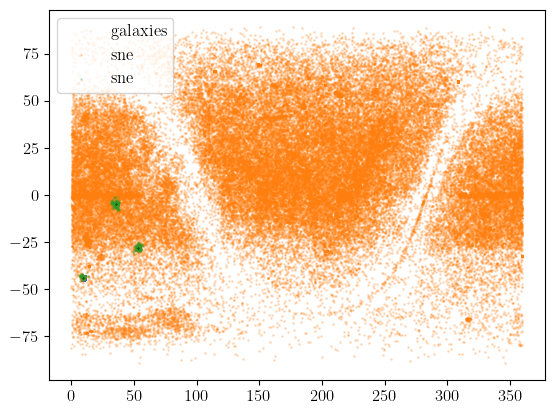

In [19]:
centers = np.array([[Angle('03:32:09', unit='hourangle').deg, Angle('-28:08:32 degrees').deg], [Angle('00:37:47', unit='hourangle').deg, Angle('-44:00:07 degrees').deg], [Angle('02:22:10', unit='hourangle').deg, Angle('-04:45:00 degrees').deg]])
plt.figure()
plt.scatter(fits_data['RA'], fits_data['DEC'], s=0.1, alpha=0.1, label='galaxies')
plt.scatter(np.array(sne_ra), np.array(sne_dec), s=1, label='sne', alpha=0.2)
plt.scatter(np.array(sne_ra)[in_field_mask][classified_mask][~nan_mask], np.array(sne_dec)[in_field_mask][classified_mask][~nan_mask], s=1, label='sne', alpha=0.2)
plt.scatter(centers[:, 0], centers[:, 1], s=0.1, color='black')
plt.legend(loc=2)
# plt.xlim((32, 40))
# plt.ylim((-7, -3))
plt.show()

In [20]:
# # Get the hosts of all the tractor_ids that only occur once
# tids, tid_counts = np.unique(final_photometry['tractor_id'], return_counts=True)
# unique_tids = tids[tid_counts == 1]

gal_coords_arr = get_coords_for_ids(final_photometry['gal_id'], lookup_table_path='/Users/adamboesky/Research/ay98/clean_data/coord_lookup_table.pkl')
gal_coords = SkyCoord(gal_coords_arr['RA'] * u.deg, gal_coords_arr['DEC'] * u.deg, frame='icrs')
smallest_seps = np.array([None for _ in range(len(classified_field_sne))])
hosts_30 = np.array([None for _ in range(len(classified_field_sne))])
hosts_60 = np.array([None for _ in range(len(classified_field_sne))])

# For each supernova, find the host galaxy
for i, coord in enumerate(concatenate(classified_field_sne['sky_coord'])):
    gal_seps = coord.separation(gal_coords).arcsec
    smallest_sep = np.min(gal_seps)
    smallest_sep_ind = np.argmin(gal_seps)
    if smallest_sep < 30:  # Host if the host is less than a 30 arcsec separation
        hosts_30[i] = final_cat['gal_id'][smallest_sep_ind]
        smallest_seps[i] = smallest_sep
    if smallest_sep < 60:  # Host if the host is less than a 30 arcsec separation
        hosts_60[i] = final_cat['gal_id'][smallest_sep_ind]

Sorted
Search complete
Validation complete


In [21]:
print(hosts_30)
print(len(hosts_30))
print(np.count_nonzero(hosts_30 != None))

[None 2336057 None None None None None None 974754 793720 1485564 None
 None None None None None None 776508 776283 None None None 806358 None
 None 1176629 None None None None None 999437 1182949 1363990 1258736
 1376520 1127393 1138637 1183192 1152894 967050 1117168 1456182 922391
 566278 None None None 711364 311657 296511 449562 2658758 None 1726055
 None None None None None None None None None 2123250 1851610 1975347
 2180253 2099915 2364463 2026120 None None None None None None None None
 None None None None None None None None 766621 None None None 920663 None
 1004836 None None 1175116 1267901 1155296 1119931 1090106 1065885 910518
 988653 1239061 1044088 1070349 1004191 1000415 1235165 1281872 1030446
 929260 None None None 523276 None None None None None None 591531 474445
 305144 50039 None 297698 291958 55062 398150 531822 750137 390579 112688
 199491 575578 None None 1688405 1518360 None None 2670102 None 2291392
 None 2286283 None 2489922 None None None None None None Non

In [22]:
classified_field_sne['host'] = hosts_30
classified_field_sne['host_angular_sep_arcsec'] = smallest_seps
classified_field_sne[['event', 'catalog', 'claimedtype', 'host', 'host_angular_sep_arcsec']].head(-10)

,event,catalog,claimedtype,host,host_angular_sep_arcsec
19,"<a id=""ASASSN-15og"">ASASSN-15og</a>",sne,Ia CSM,None,None
136,ASASSN-15od,sne,Ia,2336057,0.037172
1452,AT2017int,sne,II,None,None
25586,AT2020uew,sne,"Other,SLSN",None,None
28300,AT2020zf,sne,Ia,None,None
...,...,...,...,...,...
81473,SNLS-07D1bu,sne,Ia,1898044,0.358794
81474,SNLS-07D1bw,sne,II?,1864877,0.844114
81475,SNLS-07D1by,sne,Ia,2478359,5.33093
81476,SNLS-07D1ca,sne,"Ia?,Ia",1800608,0.344673


In [23]:
type_id_dist = classified_field_sne[['claimedtype', 'host', 'host_angular_sep_arcsec']].dropna().to_numpy()
gal_sne_types = {}
for sne_type, gal_tid, dist in type_id_dist:
    if gal_sne_types.get(gal_tid):
        gal_sne_types[gal_tid].append((sne_type, dist))
    else:
        gal_sne_types[gal_tid] = [(sne_type, dist)]

# Predict on data and then use a random forest

In [24]:
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')
import torch
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve
from neural_net import resume, CustomLoss, get_model, load_and_preprocess, normalize_arr
PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

In [25]:
# Get best model based on grid search
n_epochs = 1000
nodes_per_layer = [18, 15, 12, 9, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_model.pkl')
model.eval()

Sequential(
  (input): Linear(in_features=18, out_features=18, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=18, out_features=15, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=15, out_features=12, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=12, out_features=9, bias=True)
  (act_2): ReLU()
  (layer_3): Linear(in_features=9, out_features=6, bias=True)
  (act_3): ReLU()
  (layer_4): Linear(in_features=6, out_features=4, bias=True)
  (act_4): ReLU()
  (pre_output0): Linear(in_features=4, out_features=4, bias=True)
  (pre_output1): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)

In [26]:
# Load and preprocess the data for the NN
with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_photometry.pkl'), 'rb') as f:
    all_photo = pickle.load(f)
photo = all_photo['data']
photo_err = all_photo['data_err']

# Take log of the fluxes to make the distributions better
photo_err = np.abs(photo_err / (photo * np.log(10)))
photo = np.log10(photo)

with open(os.path.join(PATH_TO_CLEAN_DATA, 'all_cat.pkl'), 'rb') as f:
    all_cat = pickle.load(f)
cat = all_cat['data']
print(f'Fixing the error for {np.sum(all_cat["data_err"][:, 2] == 0.01)} objects')
all_cat['data_err'][:, 2][all_cat['data_err'][:, 2] == 0.01] = 0.001 # Drop the spectroscopic errors down from the already low error
cat_err = all_cat['data_err']

print('Importing photometry data')
# Filter out z>1
z_local_mask = cat[:, 2] <= 1
photo = photo[z_local_mask]
photo_err = photo_err[z_local_mask]
cat = cat[z_local_mask]
cat_err = cat_err[z_local_mask]


######################## PRE PROCESSING ########################
# Filter out nans
nan_mask = np.isnan(cat).any(axis=1)
photo_norm, photo_mean, photo_std, photo_err_norm = normalize_arr(photo[~nan_mask], errors=photo_err[~nan_mask])
cat_norm, cat_mean, cat_std, cat_err_norm = normalize_arr(cat[~nan_mask], errors=cat_err[~nan_mask])
print('HEEERRRREE', cat_norm)
print(cat_mean)
print(f'Photo stats:\n \tmean = {photo_mean}\n \tstd = {photo_std}')
print(f'Catalog stats:\n \tmean = {cat_mean}\n \tstd = {cat_std}')
print(f'Length = {len(photo)}')

Fixing the error for 96514 objects
Importing photometry data
HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[ 8.69840122 -0.65829206  0.56184221]
Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
Catalog stats:
 	mean = [ 8.69840122 -0.65829206  0.56184221]
 	std = [1.31209275 1.35189867 0.29137484]
Length = 1261630


In [27]:
print(np.nansum(nan_mask)) # don't need to mess with the ordering :)

0


In [28]:
has_sne_mask = np.isin(all_photo['gal_id'][z_local_mask], list(gal_sne_types.keys()))
print(f'Number of galaxies with SNe = {np.nansum(has_sne_mask)}')

Number of galaxies with SNe = 288


In [29]:
# Predict attributes for the galaxies that have SNe
has_sne_mask = np.isin(all_photo['gal_id'][z_local_mask], list(gal_sne_types.keys()))
photo_norm_sne, photo_err_norm_sne = photo_norm[has_sne_mask], photo_err_norm[has_sne_mask]
cat_norm_sne, cat_err_norm_sne = cat_norm[has_sne_mask], cat_err_norm[has_sne_mask]
model.eval()
gal_props_pred: torch.Tensor = model(torch.from_numpy(photo_norm_sne))
gal_props_pred_untrans = gal_props_pred.detach().numpy()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/3864854881.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(gal_props_pred_untrans[:, 0], cat_norm[has_sne_mask][:, 0])


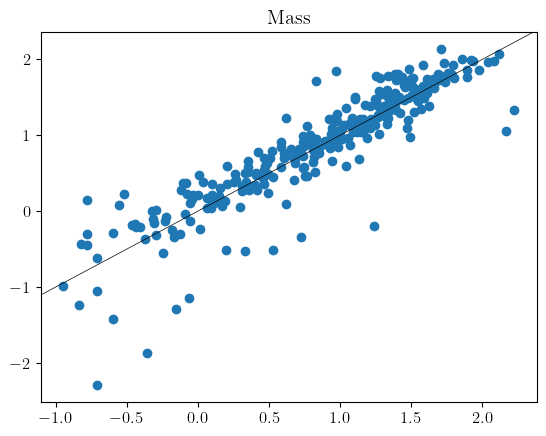

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/3864854881.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(gal_props_pred_untrans[:, 1], cat_norm[has_sne_mask][:, 1])


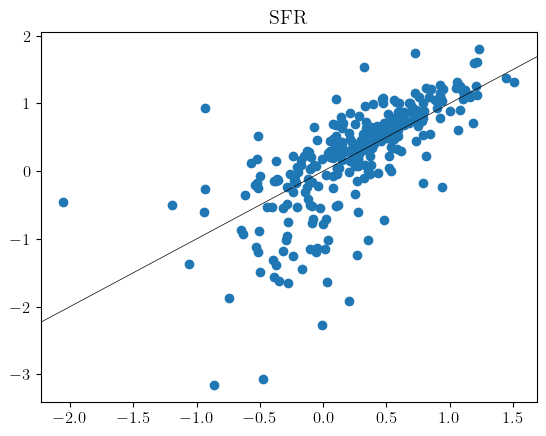

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/3864854881.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(gal_props_pred_untrans[:, 2], cat_norm[has_sne_mask][:, 2])


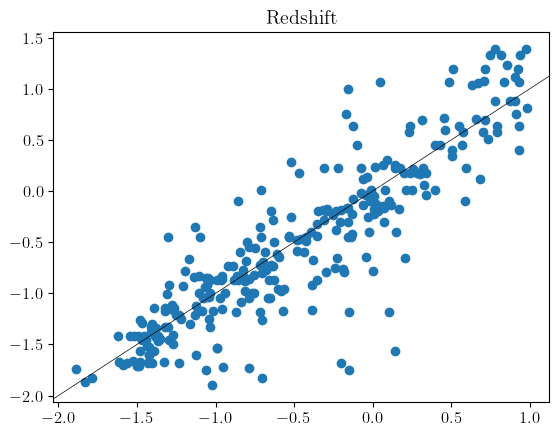

In [30]:
plt.scatter(gal_props_pred_untrans[:, 0], cat_norm[has_sne_mask][:, 0])
plt.axline((0, 0), slope=1, color='black', linewidth=0.5)
plt.title('Mass')
plt.show()
plt.scatter(gal_props_pred_untrans[:, 1], cat_norm[has_sne_mask][:, 1])
plt.axline((0, 0), slope=1, color='black', linewidth=0.5)
plt.title('SFR')
plt.show()
plt.scatter(gal_props_pred_untrans[:, 2], cat_norm[has_sne_mask][:, 2])
plt.axline((0, 0), slope=1, color='black', linewidth=0.5)
plt.title('Redshift')
plt.show()

In [31]:
# Filter the values that only appear once
tids, counts = np.unique(final_photometry['gal_id'], return_counts=True)
unique_tids = tids[counts == 1]
too_many_tids = tids[counts > 1]

# Get the attributes of the hosts for all the SNe
host_inds = []
sne_props = []
n_not_found = 0
n_multiple_tids = 0
for sn in type_id_dist:
    idx = np.where(final_photometry['gal_id'][z_local_mask][has_sne_mask] == sn[1])[0]
    if len(idx) == 1 and sn[1] in unique_tids:  # drop them if the 
        sne_props.append(sn)
        host_inds.append(idx[0])
    elif sn[1] in too_many_tids:
        n_multiple_tids += 1
    elif len(idx) == 0:
        n_not_found += 1

sne_props = np.hstack((sne_props, gal_props_pred_untrans[host_inds]))
sne_props_true = np.hstack((sne_props, cat_norm[has_sne_mask][host_inds]))
print(f'Filtering for z<1 dropped us from {len(type_id_dist)} to {len(sne_props)}. {n_not_found} were dropped because they are z>1 and {n_multiple_tids} dropped because there were multiple tractor IDs for the host. ------This issue was fixed by adding the gal_id identifier :)!!!')
print(f'SNe data is in the form (sne_type, host_gal_id, angular_dist_to_host, log_mass, log_sfr, redshift)')

Filtering for z<1 dropped us from 324 to 289. 35 were dropped because they are z>1 and 0 dropped because there were multiple tractor IDs for the host. ------This issue was fixed by adding the gal_id identifier :)!!!
SNe data is in the form (sne_type, host_gal_id, angular_dist_to_host, log_mass, log_sfr, redshift)


In [32]:
# Unregularize the data
sne_props[:, 3:] = sne_props[:, 3:] * cat_std + cat_mean

In [84]:
print('Before:\n', sne_props[:, 0])

# Conditions to check for 'ii' or 'ia' in a case-insensitive manner
condition_ii = np.vectorize(lambda s: 'ii' in s.lower())
condition_ia = np.vectorize(lambda s: 'ia' in s.lower())

# Apply conditions and choices to the string array
sne_props[:, 0] = np.where(condition_ia(sne_props[:, 0]), 0, np.where(condition_ii(sne_props[:, 0]), 1, 2))
print('After:\n', sne_props[:, 0])
print(f'The data are {np.round(100*len(sne_props[:, 0][sne_props[:, 0] == 1]) / len(sne_props), decimals=3)}% type Ia')

Before:
 ['Ia' 'Ia' 'Ic' 'Ia' 'Ia,Ia-91T' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'II' 'II' 'Ia' 'Ia' 'Ia' 'Ic' 'II' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'SLSN-I,SLSN' 'Ia' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia' 'SLSN-I'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?,Ia'
 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?'
 'SLSN-I' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c'
 'Ia' 'II?' 'Ia' 'II' 'Ia?' 'Ia Pec' 'Ia?' 'Ia?' 'Ia' 'II?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'II' 'II' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?' 'Ia' 'Ia'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II?' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'SLSN-I?' 'II' 'Ia' 'Ia'
 'Ia?' 'Ia' 'II?' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ib/c?' 'II' 'Ia'
 'Ia,Ia' 'Ia' 'IIn' 'Ia' 'II P,II' 'Ia?' 

In [33]:
print('Before:\n', sne_props[:, 0])
ia_mask = np.char.find(np.char.lower(np.array([str(item) for item in sne_props[:, 0]], dtype=str)), 'ia') != -1
sne_props[:, 0] = ia_mask.astype(int)
sne_props_true[:, 0] = ia_mask.astype(int)
print('After:\n', sne_props[:, 0])
print(f'The data are {np.round(100*len(sne_props[:, 0][sne_props[:, 0] == 1]) / len(sne_props), decimals=3)}% type Ia')

Before:
 ['Ia' 'Ia' 'Ic' 'Ia' 'Ia,Ia-91T' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'II' 'II' 'Ia' 'Ia' 'Ia' 'Ic' 'II' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'SLSN-I,SLSN' 'Ia' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia' 'SLSN-I'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?,Ia'
 'Ia' 'Ib/c' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?'
 'SLSN-I' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ib/c'
 'Ia' 'II?' 'Ia' 'II' 'Ia?' 'Ia Pec' 'Ia?' 'Ia?' 'Ia' 'II?' 'Ia' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'II' 'II' 'Ia' 'Ia?' 'II' 'Ia' 'Ia?' 'Ia' 'Ia'
 'Ia?' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia' 'II?' 'Ia' 'Ia'
 'Ia' 'Ia' 'Ia' 'II' 'Ia' 'Ia' 'Ia' 'Ia' 'Ia?' 'SLSN-I?' 'II' 'Ia' 'Ia'
 'Ia?' 'Ia' 'II?' 'Ia' 'Ia?' 'II?' 'Ia' 'Ia' 'Ia?' 'Ia' 'Ib/c?' 'II' 'Ia'
 'Ia,Ia' 'Ia' 'IIn' 'Ia' 'II P,II' 'Ia?' 

In [34]:
# Define SMOTE model
smote = SMOTE(random_state=22)

# # Fit and apply the transform
# sne_props = sne_props.astype(float)
# sne_props_X = sne_props[:, 2:]
# sne_props_y = sne_props[:, 0]
# X_resampled, y_resampled = smote.fit_resample(sne_props_X, sne_props_y)
# sne_props_train_X, sne_props_test_X, sne_props_train_y, sne_props_test_y = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=22)




# Split train and test data
sne_props = sne_props.astype(float)
sne_props_X = sne_props[:, 2:]
sne_props_y = sne_props[:, 0]
sne_props_train, sne_props_test = train_test_split(sne_props, test_size=0.2, random_state=22)
sne_props_train_X = sne_props_train[:, 2:]
sne_props_train_y= sne_props_train[:, 0]
sne_props_test_X = sne_props_test[:, 2:]
sne_props_test_y= sne_props_test[:, 0]
sne_props_X = sne_props[:, 2:]
sne_props_y = sne_props[:, 0]

# Split train and test data
sne_props_true = sne_props_true.astype(float)
sne_props_true_X = sne_props_true[:, 2:]
sne_props_true_y = sne_props_true[:, 0]
# sne_props_true_X_resampled, sne_props_true_y_resampled = smote.fit_resample(sne_props_true_X, sne_props_true_y)


## Random Forest Classifier

In [35]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=22)
X_train_resampled, y_train_resampled = smote.fit_resample(sne_props_train_X, sne_props_train_y)
rf_clf = rf_clf.fit(X_train_resampled, y_train_resampled)
preds = rf_clf.predict(sne_props_test_X)

In [36]:
print(f'Tree was right {(np.sum(preds == sne_props_test_y) * 100 / len(preds)).round(3)}% of the time!')

Tree was right 82.759% of the time!


In [37]:
conf_mat = confusion_matrix(sne_props_test_y, preds)

/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


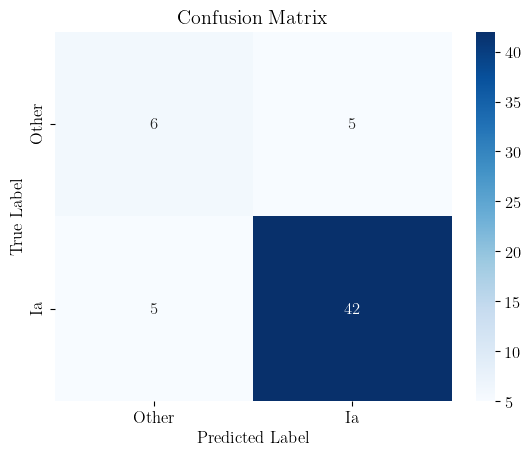

In [38]:
labels = ['Other', 'Ia']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/4060828876.py:61: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


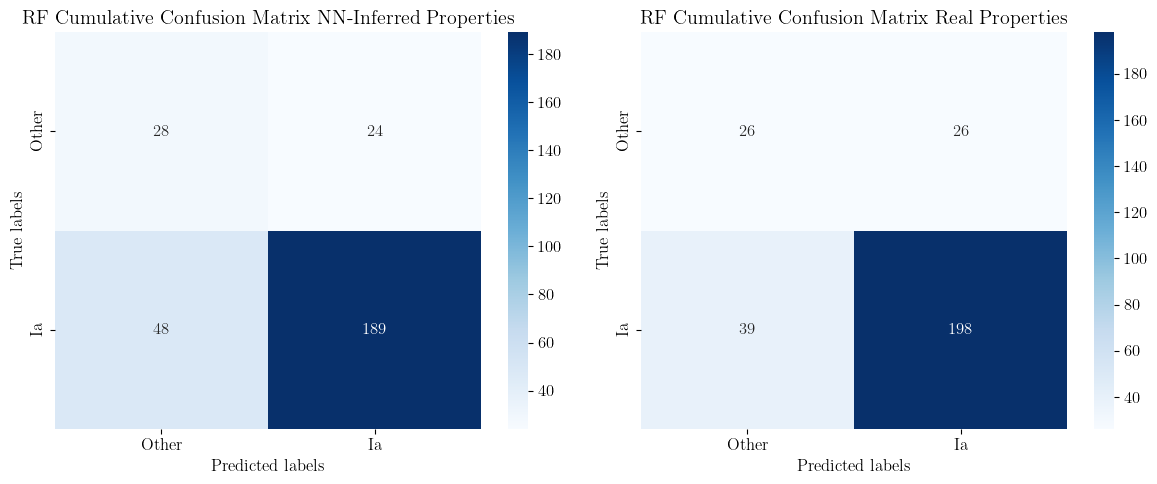

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/4060828876.py:91: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


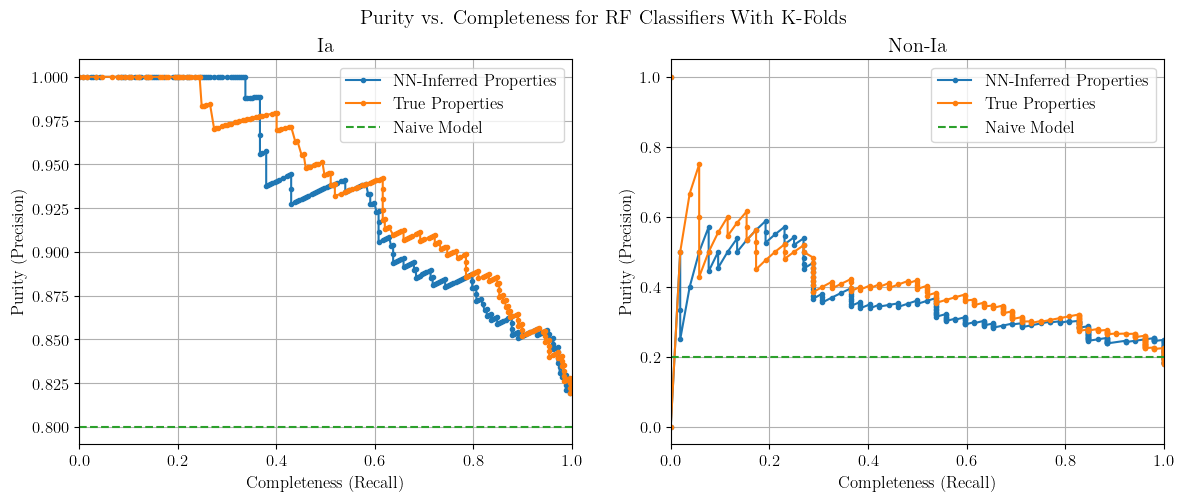

In [46]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=50, random_state=22, shuffle=True)
smote = SMOTE(random_state=22)
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=22)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []

# Iterate over each fold
for train_index, test_index in kf.split(sne_props_X, sne_props_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = sne_props_X[train_index], sne_props_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)


    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = sne_props_true_X[train_index], sne_props_true_X[test_index]
    y_true_train, y_true_test = sne_props_true_y[train_index], sne_props_true_y[test_index]

    # Do SMOTE resampling
    X_true_train, y_true_train = smote.fit_resample(X_true_train, y_true_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    rf_classifier.fit(X_true_train, y_true_train)
    y_true_pred = rf_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = rf_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)

# PLOTTING CONFUSION MATRICES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cumulative_cm, ax=ax1, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
sns.heatmap(cumulative_cm_true, ax=ax2, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
ax1.set_title('RF Cumulative Confusion Matrix NN-Inferred Properties')
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax2.set_title('RF Cumulative Confusion Matrix Real Properties')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
plt.tight_layout()
plt.show()


# PLOTTING PURITY V. COMPLETION CURVES
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Plotting purity vs. completeness
# Ia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(recall, precision, marker='.', label='NN-Inferred Properties')
ax1.plot(recall_true, precision_true, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax1.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax1.grid()
# Non-Ia
ax2.plot(recall_0, precision_0, marker='.', label='NN-Inferred Properties')
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax2.grid()

# Format
ax1.set_xlabel('Completeness (Recall)')
ax1.set_ylabel('Purity (Precision)')
ax1.set_xlim((0, 1))
plt.suptitle('Purity vs. Completeness for RF Classifiers With K-Folds')
ax1.set_title('Ia')
ax1.legend()
ax2.set_xlabel('Completeness (Recall)')
ax2.set_ylabel('Purity (Precision)')
ax2.set_xlim((0, 1))
ax2.set_title('Non-Ia')
ax2.legend()
plt.show()

In [72]:
# print(cumulative_cm, cm1_col_norms, cm1_norm[:, 0])
# print(cm1_col_norms[0])
print(cm2, cm2_norm , cm2_col_norms)

[[ 39 198]
 [ 26  26]] [[6.00000000e-01 3.94610969e-03]
 [4.00000000e-01 5.18176020e-04]] [ 65 224]


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/2484366457.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/2484366457.py:72: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


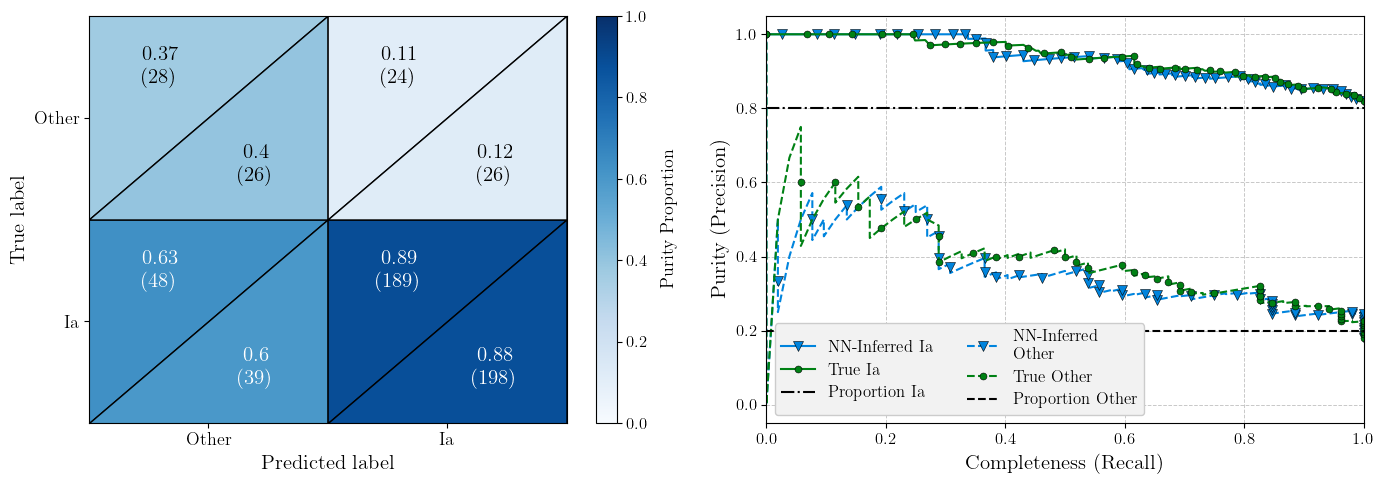

In [82]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

# Get the confusion normalized matrices
cm1_col_norms = np.sum(cm1, axis=0)
cm2_col_norms = np.sum(cm2, axis=0)
cm1_norm = cm1 / cm1_col_norms
cm2_norm = cm2 / cm2_col_norms
cm1_norm = cm1_norm.round(2)
cm2_norm = cm2_norm.round(2)


# Normalize the values for the colormap
norm = plt.Normalize(vmin=0, vmax=1)


for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1_norm[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2_norm[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1_norm[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1_norm[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}\n({})'.format(cm1_norm[i, j], cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}\n({})'.format(cm2_norm[i, j], cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Purity Proportion', labelpad=10, fontsize=13)




# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Proportion Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Proportion Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/k_fold_results.png', dpi=1000)
plt.show()

## Gradient Boosting Classifier

In [68]:
gb_clf = GradientBoostingClassifier(n_estimators=1000, random_state=22)
gb_clf = gb_clf.fit(sne_props_train_X, sne_props_train_y)
preds = gb_clf.predict(sne_props_test_X)

In [69]:
print(f'Tree was right {(np.sum(preds == sne_props_test_y) * 100 / len(preds)).round(3)}% of the time!')

Tree was right 81.034% of the time!


In [70]:
conf_mat = confusion_matrix(sne_props_test_y, preds)

/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


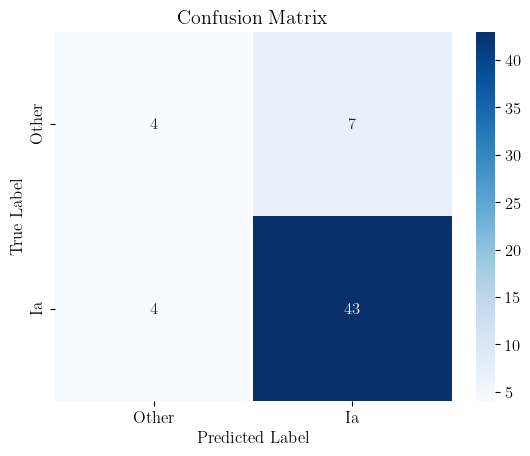

In [71]:
labels = ['Other', 'Ia']
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [72]:
cv_scores = cross_val_score(gb_clf, sne_props_X, sne_props_y, cv=20, scoring='accuracy')  # You can change the scoring parameter
print(f'CV score mean = {np.mean(cv_scores).round(3)}')

CV score mean = 0.769


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/1586887876.py:61: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


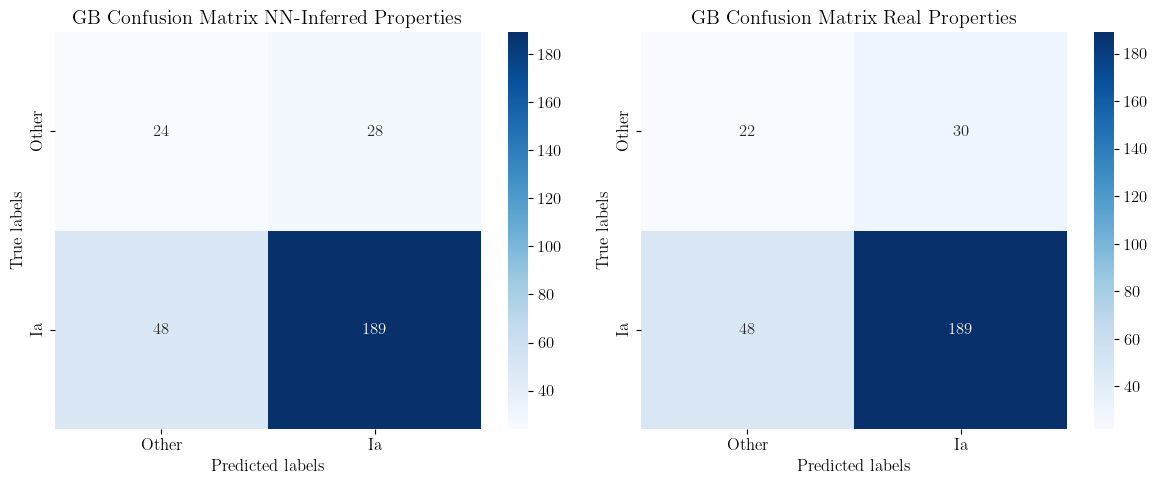

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/1586887876.py:91: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


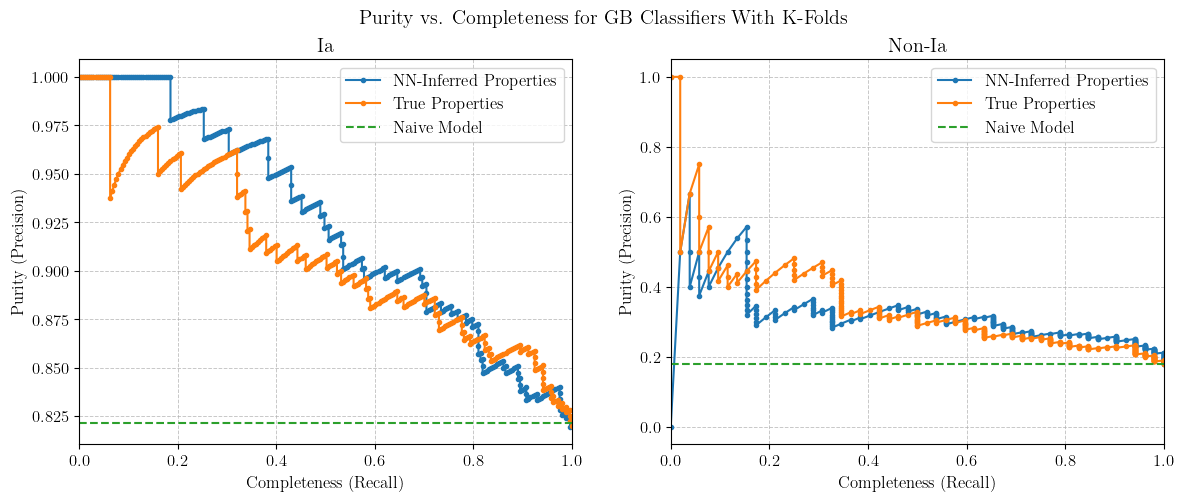

In [44]:
# K fold confusion matrix
kf = StratifiedKFold(n_splits=10, random_state=22, shuffle=True)
smote = SMOTE(random_state=22)
gb_classifier = GradientBoostingClassifier(random_state=22, n_estimators=1000)

# Initialize a matrix to hold the summed confusion matrix
cumulative_cm = np.array([[0, 0], [0, 0]])
cumulative_cm_true = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights = np.array([[0, 0], [0, 0]])
cumulative_cm_equal_weights_true = np.array([[0, 0], [0, 0]])

# Initialize lists of the scores for the purity vs. completeness graphs
y_tests = []
y_proba = []
y_tests_true = []
y_proba_true = []

# Iterate over each fold
for train_index, test_index in kf.split(sne_props_X, sne_props_y):

    ### NN-INFERRED DATA ###
    # Split the data into training and test sets for the current fold
    X_train, X_test = sne_props_X[train_index], sne_props_X[test_index]
    y_train, y_test = sne_props_y[train_index], sne_props_y[test_index]

    # Do SMOTE resampling
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    gb_classifier.fit(X_train, y_train)
    y_pred = gb_classifier.predict(X_test)
    cumulative_cm += confusion_matrix(y_test, y_pred)
    
    # Get the info for the purity vs. completeness curve
    y_pred_proba = gb_classifier.predict_proba(X_test)[:, 1]
    y_tests.append(y_test)
    y_proba.append(y_pred_proba)


    ### TRUE DERIVED DATA ###
    # Split the data into training and test sets for the current fold
    X_true_train, X_true_test = sne_props_true_X[train_index], sne_props_true_X[test_index]
    y_true_train, y_true_test = sne_props_true_y[train_index], sne_props_true_y[test_index]

    # Do SMOTE resampling
    X_true_train, y_true_train = smote.fit_resample(X_true_train, y_true_train)

    # Fit and get confusion matrix
    # Non-balanced weights
    gb_classifier.fit(X_true_train, y_true_train)
    y_true_pred = gb_classifier.predict(X_true_test)
    cumulative_cm_true += confusion_matrix(y_true_test, y_true_pred)

    # Get the info for the purity vs. completeness curve
    y_pred_proba_true = gb_classifier.predict_proba(X_true_test)[:, 1]
    y_tests_true.append(y_true_test)
    y_proba_true.append(y_pred_proba_true)

# PLOTTING CONFUSION MATRICES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cumulative_cm, ax=ax1, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
sns.heatmap(cumulative_cm_true, ax=ax2, annot=True, fmt='d', cmap='Blues', xticklabels=['Other', 'Ia'], yticklabels=['Other', 'Ia'])
ax1.set_title('GB Confusion Matrix NN-Inferred Properties')
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax2.set_title('GB Confusion Matrix Real Properties')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
plt.tight_layout()
plt.show()


# PLOTTING PURITY V. COMPLETION CURVES
# Concatenate the true labels and probabilities from each fold
y_tests = np.concatenate(y_tests)
y_proba = np.concatenate(y_proba)
y_tests_true = np.concatenate(y_tests_true)
y_proba_true = np.concatenate(y_proba_true)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_tests, y_proba)
precision_true, recall_true, thresholds_true = precision_recall_curve(y_tests_true, y_proba_true)

# Calculate precision and recall for non-Ia predictions by inverting the probabilities and labels
precision_0, recall_0, thresholds_0 = precision_recall_curve(y_tests, 1 - y_proba, pos_label=0)
precision_true_0, recall_true_0, thresholds_true_0 = precision_recall_curve(y_tests_true, 1 - y_proba_true, pos_label=0)

# Plotting purity vs. completeness
# Ia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(recall, precision, marker='.', label='NN-Inferred Properties')
ax1.plot(recall_true, precision_true, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax1.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
# Non-Ia
ax2.plot(recall_0, precision_0, marker='.', label='NN-Inferred Properties')
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Properties')
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Naive Model')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax1.set_xlabel('Completeness (Recall)')
ax1.set_ylabel('Purity (Precision)')
ax1.set_xlim((0, 1))
plt.suptitle('Purity vs. Completeness for GB Classifiers With K-Folds')
ax1.set_title('Ia')
ax1.legend()
ax2.set_xlabel('Completeness (Recall)')
ax2.set_ylabel('Purity (Precision)')
ax2.set_xlim((0, 1))
ax2.set_title('Non-Ia')
ax2.legend()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/3485029140.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_15112/3485029140.py:61: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(sm, ax=ax1)


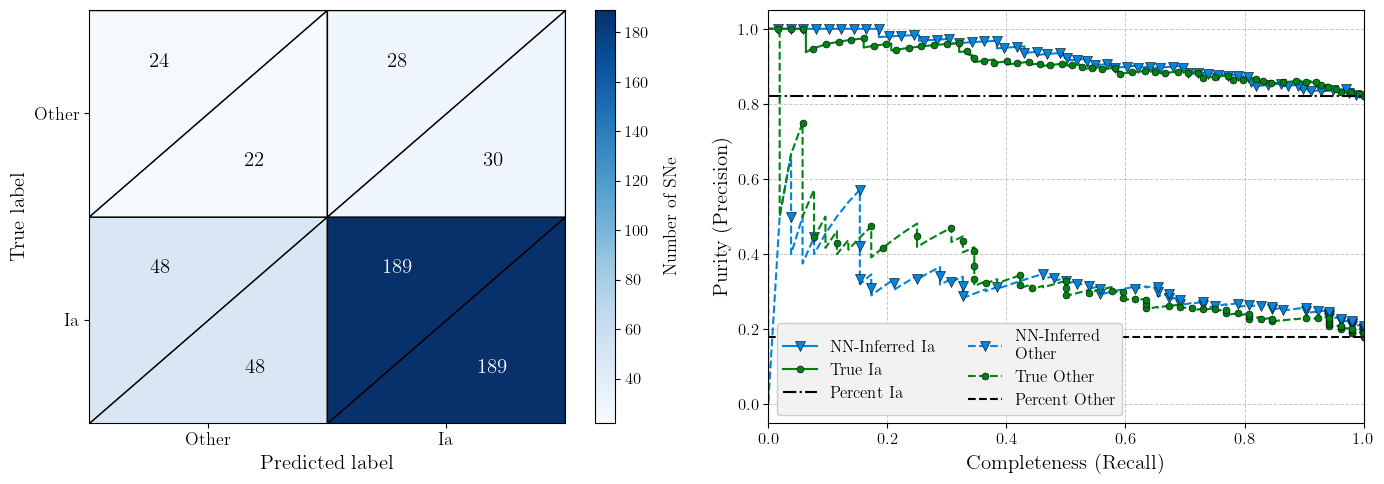

In [45]:
from matplotlib.cm import ScalarMappable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm1 = np.flipud(cumulative_cm)
cm2 = np.flipud(cumulative_cm_true)
# Normalize the values for the colormap
norm = plt.Normalize(vmin=min(cm1.min(), cm2.min()), vmax=max(cm1.max(), cm2.max()))

# Choose a colormap
cmap = plt.cm.Blues

# Define the bounds of the boxes
bounds = [0, 1, 2]

# Create a mesh grid
X, Y = np.meshgrid(bounds, bounds)

for (i, j), z in np.ndenumerate(cm1):
    # Color for the top triangle (cm1)
    color1 = cmap(norm(cm1[i, j]))

    # Color for the bottom triangle (cm2)
    color2 = cmap(norm(cm2[i, j]))

    # Split each cell diagonally
    # x1, y1 = i, j
    # x2, y2 = i+1, j+1
    # x3, y3 = i, j+1
    # x4, y4 = i + 1, j
    # # [x1, x3], [y1, y3], [y2, y2]
    ax1.fill_between([j, j+1], [i, i+1], [i+1, i+1], color=color1, edgecolor='black')
    ax1.fill_between([j, j+1], [i, i+1], [i, i], color=color2, edgecolor='black')

    # Add text
    if cm1[i, j] > 0.5*norm.vmax: col1 = 'white'
    else: col1 = 'k'
    if cm1[i, j] > 0.5*norm.vmax: col2 = 'white'
    else: col2 = 'k'
    ax1.text(j + 0.3, i + 0.75, '{}'.format(cm1[i, j]), ha='center', va='center', fontsize=15, color=col1)
    ax1.text(j + 0.7, i + 0.27, '{}'.format(cm2[i, j]), ha='center', va='center', fontsize=15, color=col1)

# Set the limits and labels
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 2)
ax1.set_xticks([0.5, 1.5])
ax1.set_yticks([0.5, 1.5])
ax1.set_xticklabels(["Other", "Ia"])
ax1.set_yticklabels(["Ia", "Other"])
ax1.tick_params(axis='both', which='major', labelsize=13)  # Adjust labelsize as needed

# Add grid, labels and title
ax1.grid(False)
ax1.set_ylabel('True label', fontsize=15)
ax1.set_xlabel('Predicted label', fontsize=15)

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Number of SNe', labelpad=10, fontsize=13)




# Ia
ax2.plot(recall, precision, marker='v', label='NN-Inferred Ia', color='#0084DD', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true, precision_true, marker='.', label='True Ia', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 1]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='-.', label='Percent Ia', color='k')
# Non-Ia
ax2.plot(recall_0, precision_0, marker='v', label='NN-Inferred \nOther', color='#0084DD', linestyle='--', markevery=5, markersize=7, mec='k', mew=0.4)
ax2.plot(recall_true_0, precision_true_0, marker='.', label='True Other', linestyle='--', color='#008114', markevery=5, markersize=10, mec='k', mew=0.4)
naive_model = len(y_test[y_test == 0]) / len(y_test)
ax2.plot([0, 1], [naive_model, naive_model], linestyle='--', label='Percent Other', color='k')
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)

# Format
ax2.set_xlabel('Completeness (Recall)', fontsize=15)
ax2.set_ylabel('Purity (Precision)', fontsize=15)
ax2.set_xlim((0, 1))
ax2.legend(fancybox=True, loc='lower left', ncol=2, framealpha=1, facecolor='#F2F2F2')
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/k_fold_results.png', dpi=1000)
plt.show()

In [86]:
sne_df = pd.DataFrame(sne_props[:, [0, 2, 3, 4, 5]], columns=[r'Supernova Type', r'Host \newline Separation [$^{\prime\prime}$]', r'$\log(M_*) \ [M_\odot]$', r'$\log(\rm{SFR}) \ [M_\odot \rm{yr}^{-1}$]', r'Redshift'])

In [87]:
sne_df.head()

,Supernova Type,Host \newline Separation [$^{\prime\prime}$],$\log(M_*) \ [M_\odot]$,$\log(\rm{SFR}) \ [M_\odot \rm{yr}^{-1}$],Redshift
0,0,0.037172,10.318529,-0.758992,0.028449
1,0,0.09511,9.209777,-1.090419,0.643561
2,2,0.768109,8.955444,-0.287169,0.331861
3,0,1.502568,8.462724,-1.040922,0.395303
4,0,0.309975,9.978939,-0.177889,0.163458


/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/axisgrid.py:1282: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  axes = fig.subplots(len(y_vars), len(x_vars),
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/axisgrid.py:1459: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  diag_ax = ax.twinx()
/Users/adamboesky/opt/anaconda3/envs/ay98/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_3802/2509747183.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


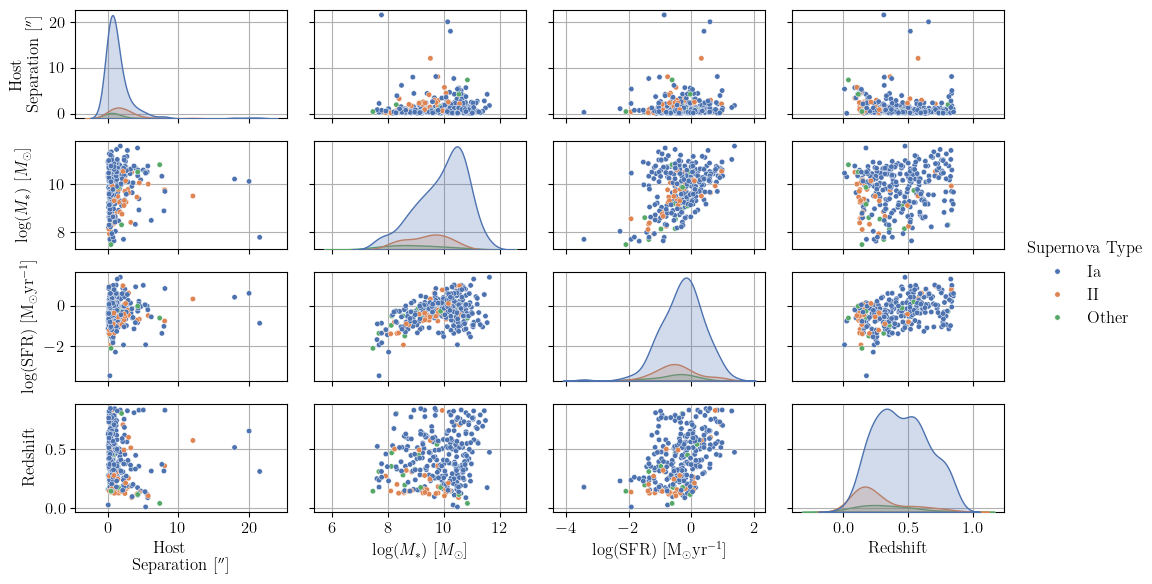

In [88]:
pp = sns.pairplot(sne_df, hue='Supernova Type', height=1.5, plot_kws={'s': 15}, palette='deep', aspect=1.5)

# Update the legend labels
label_dict = {'0.0': 'Ia', '1.0': 'II', '2.0': 'Other'}
for t, l in zip(pp._legend.texts, label_dict.values()):  # Update the texts in the legend
    t.set_text(l)

for ax in pp.axes.flatten():
    ax.set_axisbelow(True)
    ax.grid(True, zorder=-1)  # Adds grid lines
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

plt.subplots_adjust(right=0.85)  # Adjust subplot to make room
pp._legend.set_bbox_to_anchor((1.125, 0.5))  # Anchor the legend
plt.tight_layout()

# Adjusting the y-axis labels
for indx, ax in enumerate(pp.axes[:, 0]):  # Loop over the leftmost axes
    if indx == 1:
        ax.yaxis.labelpad = 13  # Adjust this value to move the y-axis label
    else:
        ax.yaxis.labelpad = 5  # Adjust this value to move the y-axis label

plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/pairplot.png', bbox_inches='tight', dpi=500)
plt.show()

In [77]:
sne_df

,Supernova Type,Host \newline Separation [$^{\prime\prime}$],$\log(M_*) \ [M_\odot]$,$\log(\rm{SFR}) \ [M_\odot \rm{yr}^{-1}$],Redshift
0,1.0,0.037172,10.318529,-0.758992,0.028449
1,1.0,0.095110,9.209777,-1.090419,0.643561
2,0.0,0.768109,8.955444,-0.287169,0.331861
3,1.0,1.502568,8.462724,-1.040922,0.395303
4,1.0,0.309975,9.978939,-0.177889,0.163458
...,...,...,...,...,...
284,1.0,0.309108,9.162323,-0.104018,0.628983
285,1.0,1.320941,11.052103,1.294544,0.826373
286,1.0,0.197503,9.128785,-0.022824,0.425279
287,1.0,0.693530,9.786377,0.116326,0.571616


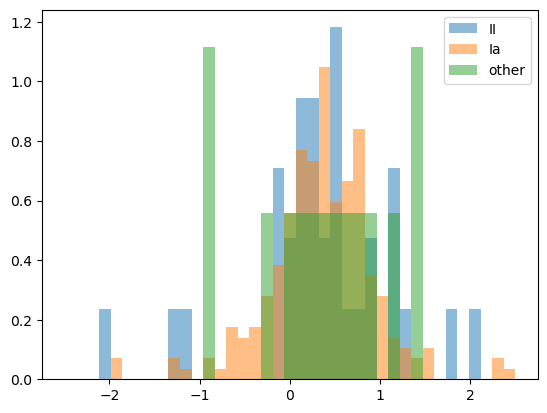

In [85]:
plt.hist(sne_df['Log(SFR)'][sne_df['Type'] == 2] / sne_df['Log(Mass)'][sne_df['Type'] == 2], alpha=0.5, bins=np.linspace(-2.5, 2.5, num=40), density=True, label = 'II')
plt.hist(sne_df['Log(SFR)'][sne_df['Type'] == 1] / sne_df['Log(Mass)'][sne_df['Type'] == 1], alpha=0.5, bins=np.linspace(-2.5, 2.5, num=40), density=True, label = 'Ia')
plt.hist(sne_df['Log(SFR)'][sne_df['Type'] == 0] / sne_df['Log(Mass)'][sne_df['Type'] == 0], alpha=0.5, bins=np.linspace(-2.5, 2.5, num=40), density=True, label = 'other')
plt.legend()
plt.show()
# plt.hist(sne_df['Log(SFR)'] / sne_df['Log(Mass)'], bins=np.linspace(-2.5, 2.5, num=40))
# plt.show()

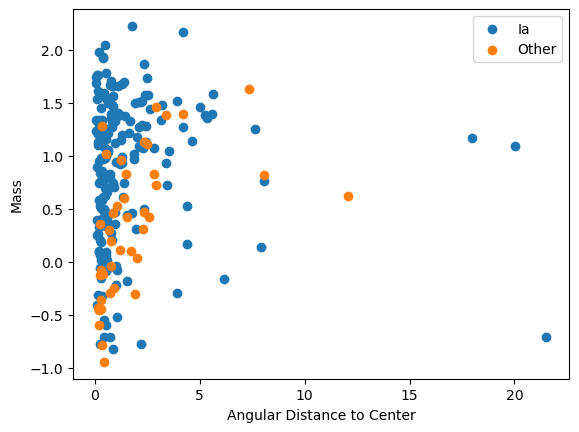

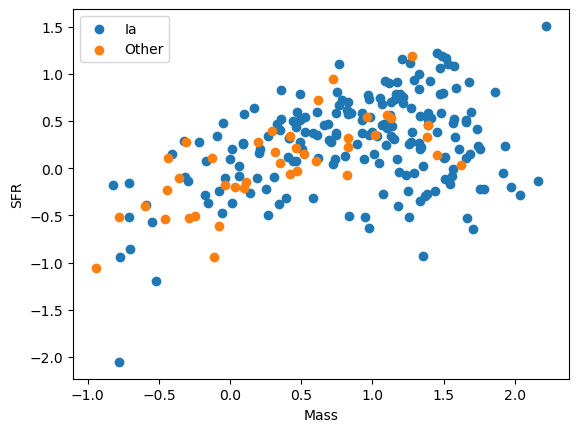

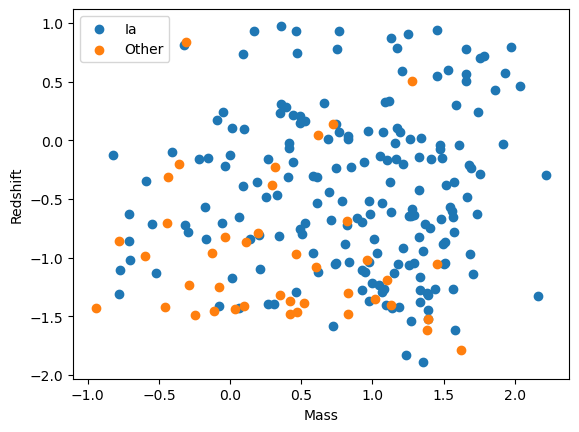

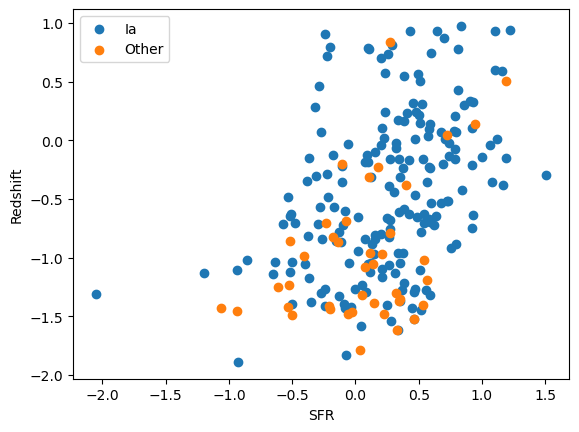

In [67]:
ia_mask = sne_props_train_y == 1
plt.scatter(sne_props_train_X[ia_mask][:, 0], sne_props_train_X[ia_mask][:, 1], label='Ia')
plt.scatter(sne_props_train_X[~ia_mask][:, 0], sne_props_train_X[~ia_mask][:, 1], label='Other')
plt.xlabel('Angular Distance to Center')
plt.ylabel('Mass')
plt.legend()
plt.show()

ia_mask = sne_props_train_y == 1
plt.scatter(sne_props_train_X[ia_mask][:, 1], sne_props_train_X[ia_mask][:, 2], label='Ia')
plt.scatter(sne_props_train_X[~ia_mask][:, 1], sne_props_train_X[~ia_mask][:, 2], label='Other')
plt.xlabel('Mass')
plt.ylabel('SFR')
plt.legend()
plt.show()


ia_mask = sne_props_train_y == 1
plt.scatter(sne_props_train_X[ia_mask][:, 1], sne_props_train_X[ia_mask][:, 3], label='Ia')
plt.scatter(sne_props_train_X[~ia_mask][:, 1], sne_props_train_X[~ia_mask][:, 3], label='Other')
plt.xlabel('Mass')
plt.ylabel('Redshift')
plt.legend()
plt.show()


ia_mask = sne_props_train_y == 1
plt.scatter(sne_props_train_X[ia_mask][:, 2], sne_props_train_X[ia_mask][:, 3], label='Ia')
plt.scatter(sne_props_train_X[~ia_mask][:, 2], sne_props_train_X[~ia_mask][:, 3], label='Other')
plt.xlabel('SFR')
plt.ylabel('Redshift')
plt.legend()
plt.show()